In [27]:
# Import packages etc...
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import itertools
import pandas as pd
from more_itertools import locate
from torch_scatter import scatter
import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
from torch_geometric.transforms import RandomNodeSplit

# Define useful functions
def concat_lists(lists):
        return list(itertools.chain.from_iterable(lists))

def pd_to_adj_matrix(df:pd.DataFrame, columns:list, weights:list):
    adj, edgeWeights = np.zeros([2,0]), []
    for i, column in enumerate(columns):
        edgeDest = [list(locate(df[column], lambda x: x==i)) for i in df[column]]
        edgeOrig = concat_lists([list(np.ones(len(x)).astype(int)*i) for i, x in enumerate(edgeDest)])
        edgeDest = concat_lists(edgeDest)
        nonSelf = np.where([val!=edgeDest[i] for i, val in enumerate(edgeOrig)])[0]
        adj = np.concatenate((adj,np.array([np.take(edgeOrig,nonSelf), np.take(edgeDest,nonSelf)])),axis=-1)
        edgeWeights = edgeWeights + [weights[i]]*len(edgeDest)
    return adj.astype(int), edgeWeights

# def draw_graph(nodes,edges,edgeWeights,nodeType):
#     graph = nx.Graph()
#     edges = zip(edges[0], edges[1], edgeWeights)
#     graph.add_weighted_edges_from(edges)
#     graph.add_nodes_from(nodes)
#     pos = nx.kamada_kawai_layout(graph)
#     fig, ax = plt.subplots(1,1,figsize=[15,15])
#     nx.draw_networkx(graph,pos, with_labels=False,node_size=50,width=0.1, node_color=nodeType, cmap=plt.cm.coolwarm)

def draw_pyg_graph(data, node_size=50, width=0.1, cmap=plt.cm.coolwarm):
    graph = to_networkx(data, to_undirected=True)
    pos = nx.kamada_kawai_layout(graph)
    fig, ax = plt.subplots(1,1,figsize=[12,12])
    nx.draw_networkx(graph,pos, with_labels=False,node_size=node_size,width=width, node_color=data.y, cmap=cmap)

In [38]:
# Import IHS data
class IHSData(object):
    def __init__(self):
        product_file = "C:/Users\lukec\OneDrive - University of Cambridge\PhD\Data\IHS/US\products.csv"
        material_file = "C:/Users\lukec\OneDrive - University of Cambridge\PhD\Data\IHS/US\materials.csv"
        self.products = pd.read_csv(product_file,index_col=0).reset_index(drop=True)
        self.materials = pd.read_csv(material_file,index_col=0).reset_index(drop=True)
        self.edgeColumns = ['Name','Geography']
        self.weights = [1,10]
        self.adjMatrix, self.edgeWeights = pd_to_adj_matrix(self.products,self.edgeColumns,self.weights)
        self.nodeTypes = self.products['Investment (MM US$)'].values
        self.valueColumns = ['Variable Cost','Fixed Costs','Overhead + Tax, Ins.','Depreciation','G&A, Sales, Res.']
        #self.products.iloc[:,np.where(['float' in i or 'int' in i for i in self.products.dtypes.astype(str)])[0]].values

    def to_pyg_graph(self):
        edge_index = torch.tensor(self.adjMatrix, dtype=torch.long)
        x = torch.tensor(self.products[self.valueColumns].values, dtype=torch.float)
        y = torch.tensor(np.digitize(self.nodeTypes,bins=np.linspace(min(self.nodeTypes),max(self.nodeTypes),4))-1, dtype=torch.long)
        return Data(x=x, edge_index=edge_index, y=y)

    def ecoinvent_emissions(self, dropna=True, single_loc=True):
        filePath = "C:/Users\lukec\OneDrive - University of Cambridge\PhD\Data\EcoInvent\Basic_chemicals_201\GWP100a_IPCC2013.csv"
        processes = pd.read_csv(filePath,index_col=0)
        emissions = processes[~processes['generalComment'].str.contains('market')].sort_values('name')
        merge = pd.merge(self.products, emissions, left_on=self.products['Name'].str.lower(), right_on=emissions['name'].str.lower(), how="left")
        if dropna: merge.dropna(subset='CO2e',inplace=True)
        if single_loc: merge.drop_duplicates('Code', inplace=True)
        return merge

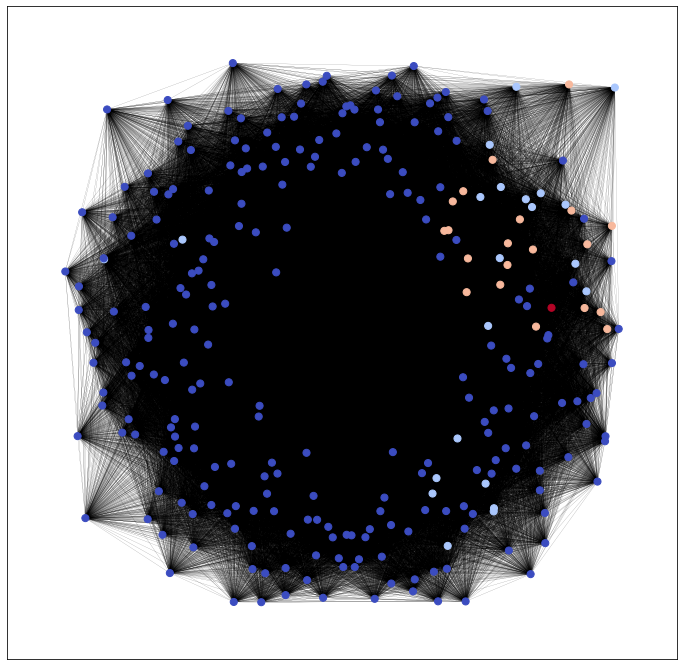

In [39]:
# Instantiate graph
ihs = IHSData()
graph = ihs.to_pyg_graph()
RandomNodeSplit('train_rest', num_val=50, num_test=50)(graph)
draw_pyg_graph(graph)
#draw_graph(data.products.index,data.adjMatrix,data.edgeWeights,pd.factorize(data.nodeTypes)[0])

In [54]:
emissions

,key_0,Code,Geography,Data Version,Research Year,Process,Unit,Base Capacity (MM unit/year),Investment (MM US$),Type,...,Plant Gate Costs,"G&A, Sales, Res.",Production Cost,ROI (15%),Product Value,Product Price,name,generalComment,location,CO2e
60,butadiene,1M-1437,"United States, Gulf Coast",2021 Q3,2012.0,"1,3-BUTADIENE BY BUTANE DEHYDROGENATION PROCESS",KG,99.790321,434.326134,Product,...,206.300256,8.399569,214.699825,65.285811,279.985635,189.222760,butadiene,Data are derived from the Eco-profiles of the ...,RER,1.200719
62,butadiene,1M-1438,"United States, Gulf Coast",2021 Q3,2012.0,"1,3-BUTADIENE BY OXIDATIVE DEHYDROGENATION",KG,99.790321,227.181648,Product,...,156.621205,5.900105,162.521310,34.148850,196.670160,189.222760,butadiene,Data are derived from the Eco-profiles of the ...,RER,1.200719
83,"2,6-di-tert-butylphenol",1M-168,"United States, Gulf Coast",2021 Q3,1993.0,"2,6-DI-TERT-BUTYLPHENOL FROM PHENOL AND ISOBUT...",KG,13.607771,37.618692,Product,...,248.347884,51.143893,299.491776,41.467509,340.959286,255.736224,"2,6-di-tert-butylphenol","2,6-Di-tert-Butylphenol is an essential input ...",GLO,3.513587
115,acetaldehyde,1M-4,"United States, Gulf Coast",2021 Q3,1976.0,ACETALDEHYDE FROM ETHYLENE BY ONE-STEP OXIDATION,KG,136.077711,156.556828,Product,...,98.009256,6.066668,104.075924,17.257436,121.333361,146.166480,acetaldehyde,This dataset represents the production of 1 kg...,RER,1.498635
137,acetic anhydride,1M-9,"United States, Gulf Coast",2021 Q3,1973.0,ACETIC ANHYDRIDE FROM ACETALDEHYDE BY DIRECT O...,KG,226.796185,473.499448,Product,...,178.865768,11.062231,189.927999,31.316628,221.244627,145.505093,acetic anhydride,This data represents the production of 1 kg of...,RER,3.501515
141,acetic anhydride,1M-10,"United States, Gulf Coast",2021 Q3,1982.0,ACETIC ANHYDRIDE FROM ACETIC ACID VIA KETENE,KG,226.796185,231.718889,Product,...,183.274920,10.452658,193.727578,15.325581,209.053159,145.505093,acetic anhydride,This data represents the production of 1 kg of...,RER,3.501515
145,acetic anhydride,1M-11,"United States, Gulf Coast",2021 Q3,1973.0,ACETIC ANHYDRIDE FROM ACETONE VIA KETENE,KG,226.796185,261.805517,Product,...,215.053177,12.229929,227.283106,17.315471,244.598577,145.505093,acetic anhydride,This data represents the production of 1 kg of...,RER,3.501515
149,acetic anhydride,1M-812,"United States, Gulf Coast",2021 Q3,1994.0,"ACETIC ANHYDRIDE FROM MEOH, ACETIC ACID, AND C...",KG,174.633062,352.220917,Product,...,120.783542,7.949334,128.732876,30.253800,158.986676,145.505093,acetic anhydride,This data represents the production of 1 kg of...,RER,3.501515
154,isopropanol,1M-1351,"United States, Gulf Coast",2021 Q3,2011.0,ACETONE HYDROGENATION TO IPA IN PHENOL MANUFAC...,KG,117.934016,27.703104,Product,...,162.155710,8.719961,170.875672,3.523551,174.399223,111.444591,isopropanol,This dataset represents the production of 1 kg...,RoW,2.272976
156,acetonitrile,1M-14,"United States, Gulf Coast",2021 Q3,1991.0,ACETONITRILE RECOVERY IN ACRYLONITRILE MANUFAC...,KG,5.443108,42.856152,Product,...,174.702332,32.533821,207.236152,118.102054,325.338206,213.275192,acetonitrile,This dataset represents the multioutput-proces...,RER,4.199721


In [41]:
emissions = ihs.ecoinvent_emissions()

ei, _ = pd_to_adj_matrix(ihs.materials[[i in emissions['Process'].values for i in ihs.materials['Target'].values]],['Source'],[1])
emissionMats = ihs.materials[[i in emissions['Process'].values for i in ihs.materials['Target'].values]].reset_index(drop=True)
matEdges = [emissionMats.index.where(emissionMats['Target'] == i).dropna().values.astype(int) for i in emissionMats['Target'].unique()]
matToProc = dict(zip(np.concatenate(matEdges), np.concatenate([np.ones(len(arr))*i for i, arr in enumerate(matEdges)]).astype(int)))
edge_index = torch.tensor(np.vectorize(matToProc.get)(ei), dtype=torch.long)

x = torch.tensor(emissions[ihs.valueColumns].values, dtype=torch.float)
y = torch.tensor(np.digitize(emissions.CO2e,bins=np.linspace(min(emissions.CO2e),max(emissions.CO2e),3))-1, dtype=torch.long)
graph = Data(x=x, edge_index=edge_index, y=y)
RandomNodeSplit('train_rest', num_val=10, num_test=10)(graph)

Data(x=[41, 5], edge_index=[2, 6596], y=[41], train_mask=[41], val_mask=[41], test_mask=[41])

In [118]:
df = pd.DataFrame([],columns=ihs.materials['Source'].unique())
grouped = pd.concat([ihs.materials.groupby('Product')[col].unique().apply(list) for col in ['Source','Value']],axis=1)
for i, proc in enumerate(emissions.Name):
    df = pd.concat([df,pd.DataFrame(grouped.loc[proc].Value, columns=grouped.loc[proc].Source)])


ValueError: Shape of passed values is (42, 1), indices imply (42, 24)

In [123]:
pd.DataFrame(grouped.loc[proc].Value, columns=grouped.loc[proc].Source)

ValueError: Shape of passed values is (42, 1), indices imply (42, 24)

In [95]:
emissions.Process

60       1,3-BUTADIENE BY BUTANE DEHYDROGENATION PROCESS
62            1,3-BUTADIENE BY OXIDATIVE DEHYDROGENATION
83     2,6-DI-TERT-BUTYLPHENOL FROM PHENOL AND ISOBUT...
115     ACETALDEHYDE FROM ETHYLENE BY ONE-STEP OXIDATION
137    ACETIC ANHYDRIDE FROM ACETALDEHYDE BY DIRECT O...
141         ACETIC ANHYDRIDE FROM ACETIC ACID VIA KETENE
145             ACETIC ANHYDRIDE FROM ACETONE VIA KETENE
149    ACETIC ANHYDRIDE FROM MEOH, ACETIC ACID, AND C...
154    ACETONE HYDROGENATION TO IPA IN PHENOL MANUFAC...
156    ACETONITRILE RECOVERY IN ACRYLONITRILE MANUFAC...
158                       ACETYLENE FROM CALCIUM CARBIDE
160            ACETYLENE FROM NATURAL GAS BY ARC PROCESS
162      ACETYLENE FROM NATURAL GAS BY PARTIAL OXIDATION
177                      ACROLEIN BY PROPYLENE OXIDATION
179              ACROLEIN PRODUCTION FROM PROPANE UPDATE
214           ACRYLONITRILE FROM PROPANE BY AMMOXIDATION
216         ACRYLONITRILE FROM PROPYLENE BY AMMOXIDATION
218         ACRYLONITRILE, PROP

# Node Classification

In [45]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, dataset, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, len(dataset.y.unique()))

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(graph, hidden_channels=16)
print(model)

from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self, dataset, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, len(dataset.y.unique()))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(graph, hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=5, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=3, bias=True)
)
GCN(
  (conv1): GCNConv(5, 16)
  (conv2): GCNConv(16, 3)
)


In [46]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(graph, hidden_channels=30)
data = graph
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 4.2679
Epoch: 002, Loss: 6.0913
Epoch: 003, Loss: 9.0005
Epoch: 004, Loss: 12.5470
Epoch: 005, Loss: 7.3937
Epoch: 006, Loss: 5.2420
Epoch: 007, Loss: 6.0972
Epoch: 008, Loss: 5.5972
Epoch: 009, Loss: 4.6478
Epoch: 010, Loss: 5.0273
Epoch: 011, Loss: 4.9448
Epoch: 012, Loss: 1.5885
Epoch: 013, Loss: 1.3369
Epoch: 014, Loss: 1.5126
Epoch: 015, Loss: 1.8496
Epoch: 016, Loss: 1.7804
Epoch: 017, Loss: 0.8476
Epoch: 018, Loss: 0.7817
Epoch: 019, Loss: 1.0268
Epoch: 020, Loss: 1.0481
Epoch: 021, Loss: 1.1834
Epoch: 022, Loss: 1.4223
Epoch: 023, Loss: 0.8155
Epoch: 024, Loss: 0.6374
Epoch: 025, Loss: 0.9178
Epoch: 026, Loss: 0.5937
Epoch: 027, Loss: 1.1479
Epoch: 028, Loss: 1.3510
Epoch: 029, Loss: 1.0061
Epoch: 030, Loss: 1.0662
Epoch: 031, Loss: 0.9630
Epoch: 032, Loss: 0.8575
Epoch: 033, Loss: 1.1435
Epoch: 034, Loss: 1.0705
Epoch: 035, Loss: 0.6585
Epoch: 036, Loss: 0.4852
Epoch: 037, Loss: 0.5541
Epoch: 038, Loss: 0.7750
Epoch: 039, Loss: 0.6255
Epoch: 040, Loss: 0.6881

C:\ProgramData\Anaconda3\envs\emissions-tracking-conda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\emissions-tracking-conda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


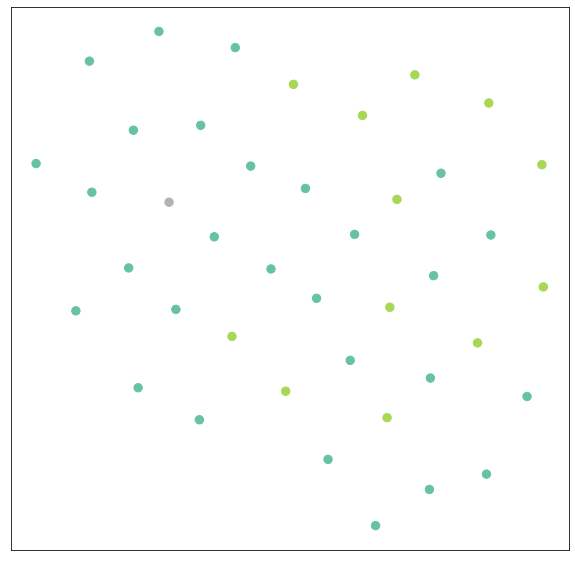

In [49]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model = GCN(graph, hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [50]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

data = graph
model = GCN(data, hidden_channels=30)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 65.7193
Epoch: 002, Loss: 52.2569
Epoch: 003, Loss: 41.0738
Epoch: 004, Loss: 33.9572
Epoch: 005, Loss: 17.4727
Epoch: 006, Loss: 8.6380
Epoch: 007, Loss: 4.5656
Epoch: 008, Loss: 9.9103
Epoch: 009, Loss: 13.7407
Epoch: 010, Loss: 16.4241
Epoch: 011, Loss: 16.9529
Epoch: 012, Loss: 15.7286
Epoch: 013, Loss: 14.9697
Epoch: 014, Loss: 15.3540
Epoch: 015, Loss: 12.2502
Epoch: 016, Loss: 12.8942
Epoch: 017, Loss: 12.8882
Epoch: 018, Loss: 9.0877
Epoch: 019, Loss: 9.8533
Epoch: 020, Loss: 7.3763
Epoch: 021, Loss: 6.7091
Epoch: 022, Loss: 0.7489
Epoch: 023, Loss: 0.8785
Epoch: 024, Loss: 3.4998
Epoch: 025, Loss: 7.3762
Epoch: 026, Loss: 8.3212
Epoch: 027, Loss: 1.7678
Epoch: 028, Loss: 8.7745
Epoch: 029, Loss: 2.4376
Epoch: 030, Loss: 1.2314
Epoch: 031, Loss: 0.9647
Epoch: 032, Loss: 1.3312
Epoch: 033, Loss: 0.8959
Epoch: 034, Loss: 3.8103
Epoch: 035, Loss: 5.2349
Epoch: 036, Loss: 3.1022
Epoch: 037, Loss: 1.5271
Epoch: 038, Loss: 3.3459
Epoch: 039, Loss: 3.0978
Epoch: 040,

C:\ProgramData\Anaconda3\envs\emissions-tracking-conda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\emissions-tracking-conda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


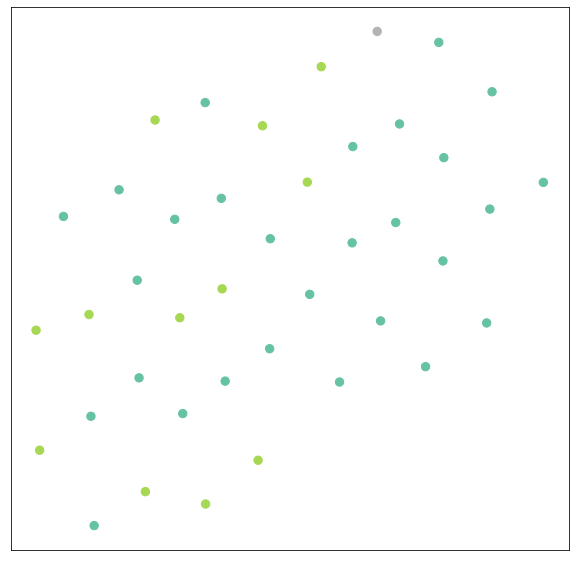

In [51]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
# Compare vs normal neural network
from torch import nn

class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))
net = Net(X_train.shape[1])

# Message passing

In [22]:
# Create message passing step
from torch_geometric.utils import add_self_loops
class SimpleMPStep(MessagePassing):
    def __init__(self, aggr):#in_channels, out_channels):
        super().__init__(aggr=aggr)

    def forward(self, h, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=h.size(0))
        out = self.propagate(edge_index, h=h)#, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j):#, edge_attr):
        msg = torch.cat([h_i, h_j], dim=-1)
        return msg #self.mlp_msg(msg)

    def aggregate(self, inputs, index):
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

    def update(self, aggr_out, h):
        upd_out = aggr_out#torch.cat([h, aggr_out], dim=-1)
        return upd_out# self.mlp_upd(upd_out)

In [24]:
# Test step
graph.y = ihs.nodeTypes
prop = SimpleMPStep('mean')
output = prop(torch.tensor([[i] for i in np.array(graph.y)]), graph.edge_index)
display(output)
#draw_graph(ihs.products.index,ihs.adjMatrix,ihs.edgeWeights,output[:,-1])

tensor([[ 884.9054, 1787.6323],
        [ 937.9998, 1891.3506],
        [ 778.7168, 1580.1957],
        [ 584.0376, 1199.8952],
        [2603.1215, 1917.9140],
        [2759.3088, 2016.0872],
        [2290.7469, 1721.5677],
        [1718.0602, 1361.5995],
        [3384.0580, 2716.9431],
        [3019.6210, 2492.3027],
        [2889.4867, 1943.7892],
        [3062.8559, 2041.6555],
        [2542.7483, 1748.0565],
        [1907.0612, 1389.2133],
        [3756.3327, 2771.4670],
        [3351.8046, 2548.4303],
        [1703.6709, 1836.6422],
        [1805.8911, 1935.7791],
        [1499.2304, 1638.3685],
        [1124.4228, 1274.8668],
        [2214.7721, 2545.6877],
        [1976.2582, 2316.0104],
        [2816.4539, 1880.6328],
        [2985.4411, 1982.2049],
        [2478.4794, 1677.4885],
        [1858.8596, 1305.0573],
        [2856.3391, 1940.7940],
        [3027.7195, 2038.6959],
        [2513.5784, 1744.9904],
        [1885.1838, 1386.0169],
        [3713.2408, 2765.1557],
        

In [16]:
# Create model that uses message passing step
class MPModel(torch.nn.Module):
    def __init__(self, num_layers=3):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(SimpleMPStep(aggr='mean'))

    def forward(self, data):
        h = data.x

        for conv in self.convs:
            h = conv(h, data.edge_index)

        out = h

        return out

In [21]:
model=MPModel(num_layers=2)
model.train()

MPModel(
  (convs): ModuleList(
    (0): SimpleMPStep()
    (1): SimpleMPStep()
  )
)

In [26]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, dataset, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, 1)
        #self.lin2 = Linear(hidden_channels, len(graph.y.unique()))

    def forward(self, x):
        x = self.lin1(x)
        # x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)
        # x = self.lin2(x)
        return x

model = MLP(graph, hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=14, out_features=1, bias=True)
)


In [27]:
model = MLP(graph, hidden_channels=16)
criterion = torch.nn.MSELoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(graph.x)  # Perform a single forward pass.
      loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(graph.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[graph.test_mask] == graph.y[graph.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(graph.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1673160.7500
Epoch: 002, Loss: 1617717.0000
Epoch: 003, Loss: 1568157.3750
Epoch: 004, Loss: 1524546.0000
Epoch: 005, Loss: 1486883.0000
Epoch: 006, Loss: 1455085.3750
Epoch: 007, Loss: 1428964.6250
Epoch: 008, Loss: 1408203.6250
Epoch: 009, Loss: 1392338.6250
Epoch: 010, Loss: 1380752.5000
Epoch: 011, Loss: 1372693.0000
Epoch: 012, Loss: 1367314.5000
Epoch: 013, Loss: 1363748.3750
Epoch: 014, Loss: 1361179.7500
Epoch: 015, Loss: 1358915.8750
Epoch: 016, Loss: 1356427.3750
Epoch: 017, Loss: 1353357.2500
Epoch: 018, Loss: 1349507.7500
Epoch: 019, Loss: 1344813.0000
Epoch: 020, Loss: 1339307.0000
Epoch: 021, Loss: 1333093.8750
Epoch: 022, Loss: 1326321.1250
Epoch: 023, Loss: 1319158.0000
Epoch: 024, Loss: 1311778.7500
Epoch: 025, Loss: 1304349.0000
Epoch: 026, Loss: 1297016.5000
Epoch: 027, Loss: 1289904.7500
Epoch: 028, Loss: 1283107.6250
Epoch: 029, Loss: 1276689.1250
Epoch: 030, Loss: 1270683.2500
Epoch: 031, Loss: 1265096.2500
Epoch: 032, Loss: 1259910.1250
Epoch: 0

C:\ProgramData\Anaconda3\envs\emissions-tracking-conda\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([144])) that is different to the input size (torch.Size([144, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [83]:
# Create model that uses message passing step

class MPModel(torch.nn.Module):
    def __init__(self, num_layers=3):#, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        #self.lin_in = Linear(in_dim, emb_dim)

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(SimpleMPStep(aggr='mean'))#MPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        #self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        #self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = data.x #self.lin_in(data.x) # (n, d_n) -> (n, d)

        for conv in self.convs:
            h = conv(h, data.edge_index)#, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        #h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = h#self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out#.view(-1)

In [162]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class MPStep(MessagePassing):
    def __init__(self, aggr):#in_channels, out_channels):
        super().__init__(aggr=aggr)  # "Add" aggregation (Step 5).
        #self.lin = torch.nn.Linear(in_channels, out_channels)

    # def forward(self, x, edge_index):
    #     # x has shape [N, in_channels]
    #     # edge_index has shape [2, E]
    #
    #     # Step 1: Add self-loops to the adjacency matrix.
    #     #edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
    #
    #     # Step 2: Linearly transform node feature matrix.
    #     x = x#self.lin(x)
    #
    #     # Step 3: Compute normalization.
    #     # row, col = edge_index
    #     # deg = degree(col, x.size(0), dtype=x.dtype)
    #     # deg_inv_sqrt = deg.pow(-0.5)
    #     # deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    #     # norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
    #
    #     # Step 4-5: Start propagating messages.
    #     return self.propagate(edge_index, x=x)#, norm=norm)
    #
    # # def message(self, x_j, norm):
    # #     # x_j has shape [E, out_channels]
    # #
    # #     # Step 4: Normalize node features.
    # #     return norm.view(-1, 1) * x_j



    def forward(self, h, edge_index):#, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the
        message passing procedure: `message()` -> `aggregate()` -> `update()`.

        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`,
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        #edge_index, _ = add_self_loops(edge_index, num_nodes=h.size(0))
        out = self.propagate(edge_index, h=h)#, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j):#, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take
        any arguments that were initially passed to `propagate`. Additionally,
        we can differentiate destination nodes and source nodes by appending
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`.

        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features

        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        msg = torch.cat([h_i, h_j], dim=-1)
        return msg #self.mlp_msg(msg)

    def aggregate(self, inputs, index):
        """Step (2) Aggregate

        The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`,
        as well as any optional arguments that were initially passed to
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = aggr_out#torch.cat([h, aggr_out], dim=-1)
        return upd_out# self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={0}, aggr={self.aggr})')

In [163]:
prop = MPStep('mean')
output = prop(graph.x, graph.edge_index)

In [254]:
model=MPModel(num_layers=1)
model.train()

MPModel(
  (convs): ModuleList(
    (0): SimpleMPStep()
  )
)

In [100]:
for epoch in range(10):
    out = model(graph.subgraph(torch.tensor(range(100))))

In [257]:
graph.num_features

14

In [255]:
optimizer = torch.optim.RMSprop(model.parameters())

ValueError: optimizer got an empty parameter list

In [209]:
from torch import functional
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MPModel().to(device)
data = graph.to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(10):
    optimizer.zero_grad()
    out = model(data)
    loss = functional.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

RuntimeError: The size of tensor a (2) must match the size of tensor b (4) at non-singleton dimension 1

In [206]:
graph.subgraph(torch.tensor(range(100)))

Data(x=[100, 1], edge_index=[2, 428])

In [207]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [173]:
import time
from num
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (y_pred * std - data.y * std).abs().sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):

    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)

    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)

        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)

        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')

        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))

    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")

    return best_val_error, test_error, train_time, perf_per_epoch

In [174]:
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)
RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

NameError: name 'train_loader' is not defined

In [164]:
output

tensor([[ 884.9055,  766.9180],
        [ 937.9998,  749.2200],
        [ 778.7168,  802.3143],
        [ 584.0376,  867.2073],
        [2603.1216, 2634.3589],
        [2759.3088, 2603.1216],
        [2290.7468, 2696.8340],
        [1718.0602, 2811.3716],
        [3384.0581, 2478.1719],
        [3019.6208, 2551.0593],
        [2889.4866, 2924.1606],
        [3062.8560, 2889.4868],
        [2542.7483, 2993.5083],
        [1907.0612, 3120.6458],
        [3756.3328, 2750.7915],
        [3351.8042, 2831.6970],
        [1703.6709, 1724.1149],
        [1805.8910, 1703.6709],
        [1499.2303, 1765.0029],
        [1124.4227, 1839.9645],
        [2214.7722, 1621.8948],
        [1976.2582, 1669.5974],
        [2816.4539, 2440.9268],
        [2985.4412, 2384.5977],
        [2478.4795, 2553.5850],
        [1858.8597, 2760.1250],
        [2856.3391, 2890.6152],
        [3027.7195, 2856.3394],
        [2513.5784, 2959.1675],
        [1885.1838, 3084.8462],
        [3713.2410, 2719.2349],
        

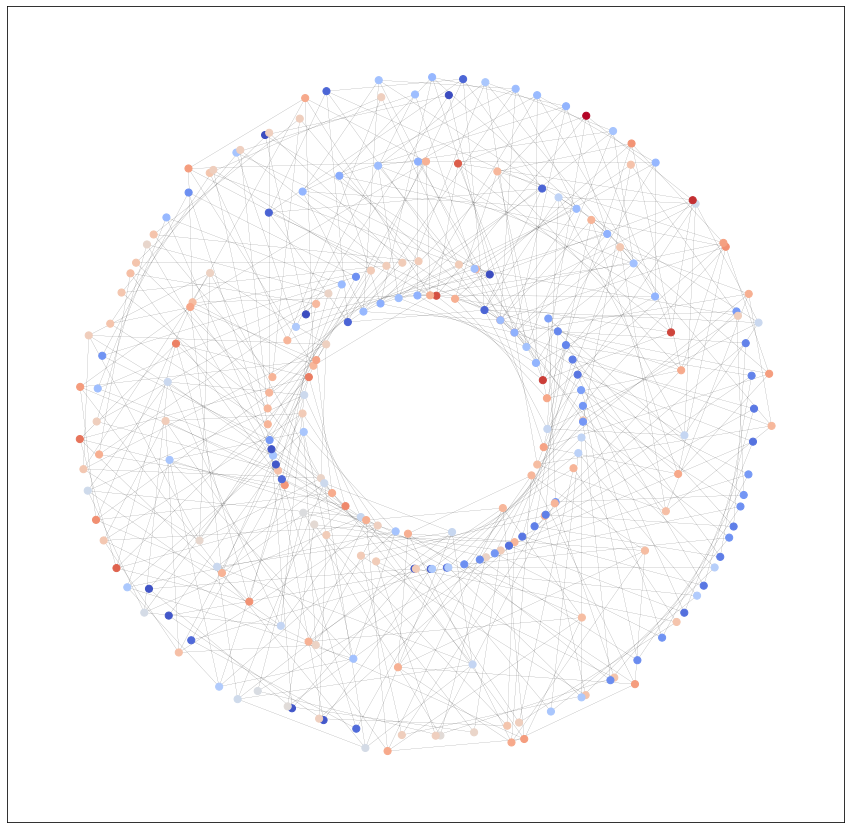

In [165]:
draw_graph(data.products.index,data.adjMatrix,data.edgeWeights,output[:,-1])

In [26]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [30]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

In [32]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8040


In [111]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [112]:
Data(x=rawdata.products[rawdata.products.columns[2:]].values,edge_index=)

Data(x=[244, 1], edge_index=[2, 972])

In [113]:
rawdata=IHSData()

In [119]:
rawdata.products[rawdata.products.columns[2:]].values

array([['2021 Q3', 2002.0,
        'ETHYLENE BY THE UOP/HYDRO METHANOL TO OLEFINS PROCESS', ...,
        33.1782743548072, 92.7226338564479, 100.420560425212],
       ['2021 Q3', 2002.0,
        'ETHYLENE BY THE UOP/HYDRO METHANOL TO OLEFINS PROCESS', ...,
        35.1689708160956, 153.722837974203, 135.826799732103],
       ['2021 Q3', 2002.0,
        'ETHYLENE BY THE UOP/HYDRO METHANOL TO OLEFINS PROCESS', ...,
        29.1968814322303, 159.850421987327, 100.354421746556],
       ...,
       ['2021 Q3', 2014.0,
        'METHANOL TO OLEFINS BY UOP ADVANCED MTO PROCESS', ...,
        33.2836324863977, 161.86111558169, 135.826799732103],
       ['2021 Q3', 2014.0,
        'METHANOL TO OLEFINS BY UOP ADVANCED MTO PROCESS', ...,
        27.6316948943679, 176.892824448681, 100.354421746556],
       ['2021 Q3', 2014.0,
        'METHANOL TO OLEFINS BY UOP ADVANCED MTO PROCESS', ...,
        20.723771170776, 129.933809640117, 97.5325047905898]],
      dtype=object)